# Benchmarking

## Overview [Public API]

It is important that we be able to assess solver performance across different:
* runs
* target states
* optimization hyperparameters
* solver implementations

etc.

As such, we have some benchmarking utilities provided in our code (with more to come).

## Benchmark circuits [Public API]

We have a set of benchmark circuits, which were used to assess the initial performance of our `EvolutionarySolver`. We expect this suite of circuits to grow as we test things further.

Each benchmark circuit function returns two things:
1. An example circuit which returns the target state
2. The ideal target state (currently as a dictionary)

Currently available benchmark circuits:
* Bell state circuit/state
* 3 and 4 qubit GHZ circuit/state
* 3 and 4 qubit linear cluster states

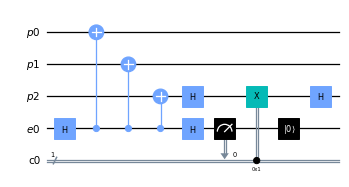

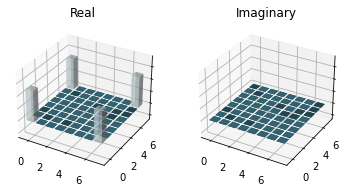

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [1]:
""" Example benchmark circuits (we've previously seen them in examples)"""
from benchmarks.circuits import ghz3_state_circuit

circuit, ideal_state = ghz3_state_circuit()
circuit.draw_circuit()
ideal_state.dm.draw()

**NOTE:** Note that the target state is returned as a `QuantumState` object

## Benchmark Graph States

Graph states are a particular type of quantum state which we are interested in generating through our inverse design algorithms. We offer functions through which certain useful types of graphs can be randomly generated.

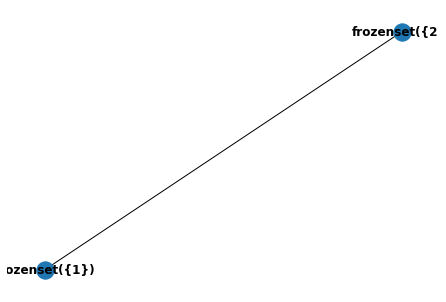

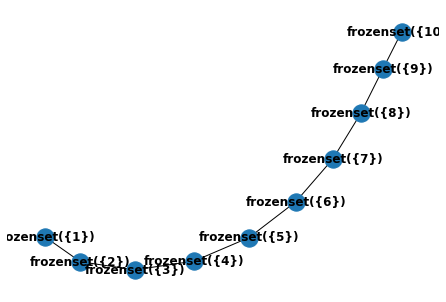

In [2]:
""" Linear cluster state """
import benchmarks.graph_states as gs

# NOTE: no randomness in these states, other than choice of indexing
gs.linear_cluster_state(2).draw()
gs.linear_cluster_state(10).draw()

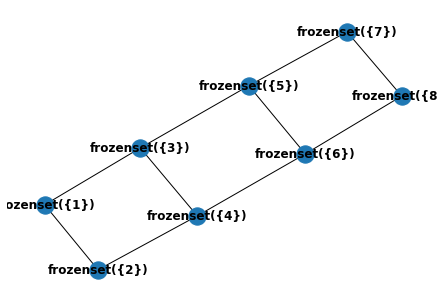

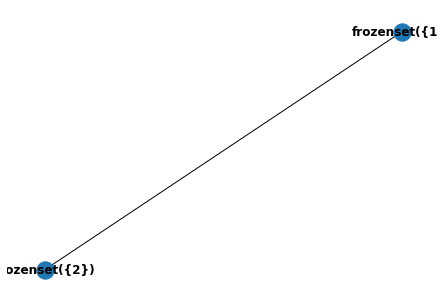

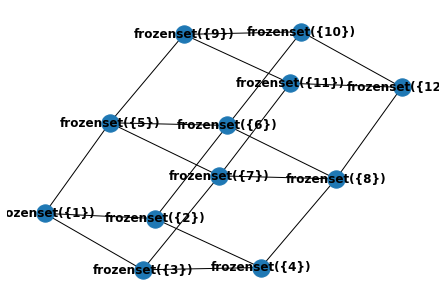

In [3]:
""" Lattice cluster state """

gs.lattice_cluster_state((2, 4)).draw()

gs.lattice_cluster_state((2,)).draw()

gs.lattice_cluster_state((2, 2, 3)).draw()

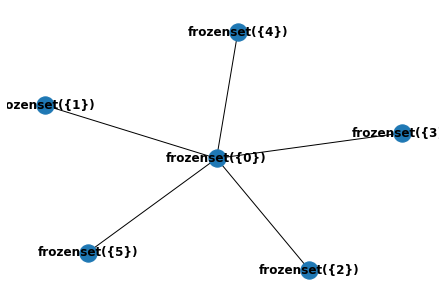

In [4]:
""" Star graph state """

num_points = 5

gs.star_graph_state(num_points).draw()

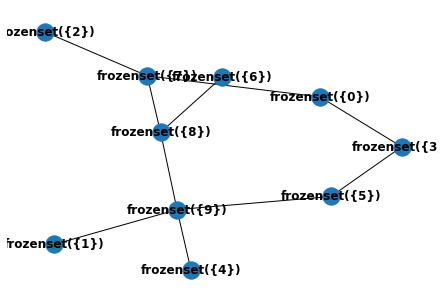

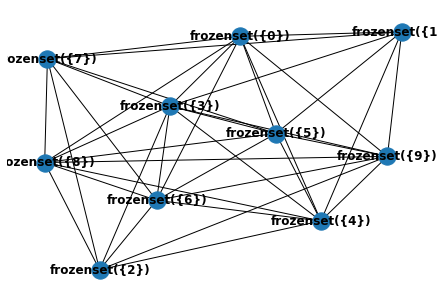

In [5]:
""" Random connected graph state """

# NOTE that this function optionally takes an rng (random number generator) object
# An rng with a specific should ALWAYS be specified when benchmarking such that
# results are replicable
import numpy as np

n_qubits = 10
# Sparse circuit
prob_edge = 0.1  # this is the probability of an edge (ignoring edges necessary for connectedness)
rng = np.random.default_rng(4)
gs.random_graph_state(n_qubits, prob_edge, rng).draw()

# Dense circuit
prob_edge = 0.9  # this is the probability of an edge (ignoring edges necessary for connectedness)
rng = np.random.default_rng(4)
gs.random_graph_state(n_qubits, prob_edge, rng).draw()

### LC Equivalence

Local Clifford (LC) Equivalence is significant in graph states, because local complementation tends to be easy to implement in quantum computing. Thus, if we can find a state which is LC equivalent to another, we can also easily find the other state.

Thus, we provide a functionality to generate LC equivalent states, from a starting circuit using `random_lc_equivalent` (see docstring).

This could be useful, for example, for determining whether all LC equivalent states are equally easy to find or not (given a specific solver).

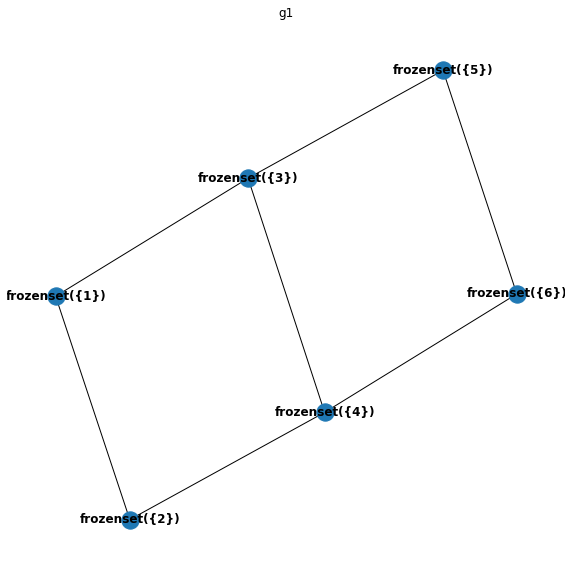

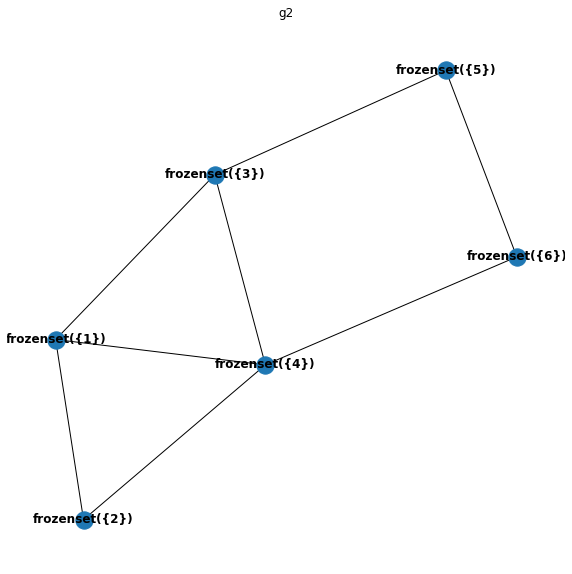

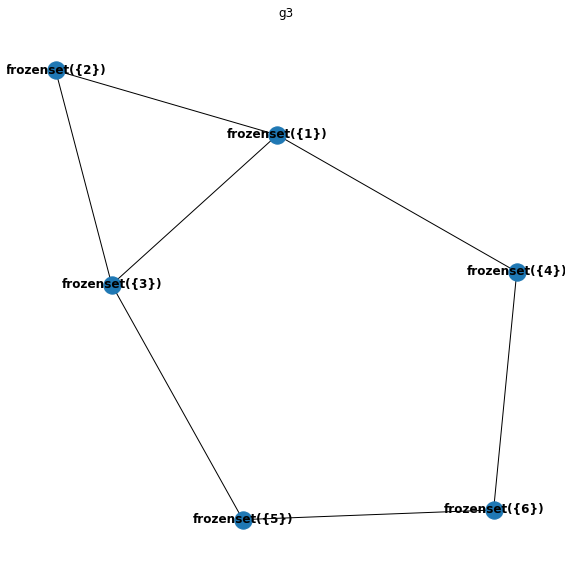

g1, g2 LC equivalent: True
g1, g3 LC equivalent: True
g2, g3 LC equivalent: True


In [6]:
# lc_equivalence_demo calls on random_lc_equivalent on a lattice state

gs.lc_equivalence_demo()

## Benchmark: Utils and Pipeline

Our benchmarking pipeline help manage different solver runs, and mediates the information collection, data saving, and multi-core computing distribution.

`benchmark_utils.py` was used for earlier data collection, but `pipeline.py` should be used for most future benchmarking tasks. It allows our code to run on multiple cores through a python package called `ray`.

A good example of how to use the pipeline is in the `__main__` function of `pipeline.py`, so we won't duplicate the example here.

### Functions offered by `pipeline.py`
* `metadata()`: collects a data dictionary about the machine running the tests
* `run_combinations`: allow us to generate all possible combinations different combinations of solvers/targets/compilers/target metrics, and returns a list of dictionaries, each capable of being used for a benchmark run
* `benchmark_run`: benchmarks a single solver run
* `benchmark`: benchmarks a sequence of runs

### Data generated in benchmark runs
* Machine metadata
* Runtime of a benchmark run
* Generated populations / halls of fame (circuits expressed as openQASM)
* Solver logs at each iteration, for both the population and hall of fame (include interation number, statistics for the cost function cost, statistics for the circuit depths)
* Class / information about the solver, compiler, etc.

### Benchmarking consideration: measurement results and probabilistic effects

One word of warning about solver data.

We have probabilistic events occurring in our circuit simulation. Currently, we do not evaluate circuits multiple times in the solver. This means that the cost functions noted in the per-iteration logs are dependent only on one run, even if they might have failed in another run.

For example, a circuit may generate the correct output state if a Z measurement on emitter 0 returns 1, and return an incorrect output state otherwise. **This is not reflected in our solver data.**

Thus, before deciding a given circuit design is optimal, we should either test all possible measurement combinations (there are 2^n possible  combinations for n measurements which lead to probabilistic gate application), or probabilistically simulate the circuit repeatedly and see whether its output is consistent.

It may useful to add some benchmarking functionality to that effect, in the future.

**NOTE:** the function `circuit_measurement_independent` in `benchmark_utils.py` was used for this purpose in earlier tests. However, it is only guaranteed to work in cases where only 1 probabilistic gate application.